# Imports

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# feature extraction and preprocessing
import re
import datetime

# feature transformation and preprocessing
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Auxiliary Functions

The function below will enable us to observe the missing values as a percentage per feature.

In [2]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent],
                              axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1))

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

The function below will enable us to plot a histogram

In [3]:
def plot_histogram(df, column, b="auto"):
    # funtion to print histogram
    # with mean and median
    # using distplot

    # set the histogram, mean and median
    # g = sns.distplot(df[column],
    #                  kde=False,
    #                  bins=b)
    g = sns.histplot(df[column], kde=False, bins=b)
    plt.axvline(x=df[column].mean(),
                linewidth=3,
                color='g',
                label="mean",
                alpha=0.5)
    plt.axvline(x=df[column].median(),
                linewidth=3,
                color='y',
                label="median",
                alpha=0.5)

    # set title, legends and labels
    plt.xlabel("{}".format(column),
               size=14)
    plt.ylabel("Count",
               size=14)
    plt.title("Distribution of {}".format(column),
              size=16)
    plt.legend(["mean", "median"])

    return g


# Understand & Clean & Format Data

In [4]:
train = pd.read_csv("../data/train/train.csv") 
test = pd.read_csv("../data/test/test.csv")
train.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
417,France,94–96. Barrel sample. Intense black currant fr...,Barrel Sample,95,NaN,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Pichon Longueville Comtesse de Lalande...,Bordeaux-style Red Blend,Château Pichon Longueville Comtesse de Lalande
3448,Argentina,"Tart, lean red fruit aromas don't give much re...",NaN,82,9.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Casa de Campo 2008 Malbec (Mendoza),Malbec,Casa de Campo
203,US,The volatiles are quite amped on this wine. It...,NaN,84,34.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Martinez & Martinez 2013 Cabernet Sauvignon (H...,Cabernet Sauvignon,Martinez & Martinez
4529,France,This estate has produced an impressive wine fo...,NaN,93,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Branaire-Ducru 2013 Saint-Julien,Bordeaux-style Red Blend,Château Branaire-Ducru
1644,Argentina,"Standard all the way, but isn't that what we w...",NaN,86,9.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Cruz Alta 2009 Malbec (Mendoza),Malbec,Cruz Alta


In [5]:
print("There are {} rows and {} columns in the train dataset."
      .format(train.shape[0], train.shape[1]))

There are 9000 rows and 13 columns in the train dataset.


In [6]:
print("There are {} rows and {} columns in the test dataset."
      .format(test.shape[0], test.shape[1]))

There are 1000 rows and 13 columns in the test dataset.


## Descriptive statistics & information about datasets

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                8994 non-null   object 
 1   description            9000 non-null   object 
 2   designation            6455 non-null   object 
 3   points                 9000 non-null   int64  
 4   price                  8403 non-null   float64
 5   province               8994 non-null   object 
 6   region_1               7505 non-null   object 
 7   region_2               3469 non-null   object 
 8   taster_name            7223 non-null   object 
 9   taster_twitter_handle  6888 non-null   object 
 10  title                  9000 non-null   object 
 11  variety                9000 non-null   object 
 12  winery                 9000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 914.2+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                1000 non-null   object 
 1   description            1000 non-null   object 
 2   designation            716 non-null    object 
 3   points                 1000 non-null   int64  
 4   price                  920 non-null    float64
 5   province               1000 non-null   object 
 6   region_1               831 non-null    object 
 7   region_2               384 non-null    object 
 8   taster_name            792 non-null    object 
 9   taster_twitter_handle  756 non-null    object 
 10  title                  1000 non-null   object 
 11  variety                1000 non-null   object 
 12  winery                 1000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 101.7+ KB


In [9]:
train.describe()

,points,price
count,9000.000000,8403.000000
mean,88.455222,35.532191
std,3.025945,40.750683
min,80.000000,5.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,1300.000000


Majority of the features are categorical and we have some missing data in the both datasets. Machine learning models can only work with numerical and non-empty values. Thus we are going to develop strategies in Feature Engineering to impute the missing data and transform categorical values into the numeric values.

In [10]:
test.describe()

,points,price
count,1000.000000,920.000000
mean,88.503000,34.675000
std,3.067475,42.240874
min,80.000000,7.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,41.000000
max,97.000000,1000.000000


## Description of features and target

In [11]:
train.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,US,"Expressive aromas of smoke, embers and blue fr...",NaN,88,35.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Damsel 2013 Syrah (Columbia Valley (WA)),Syrah,Damsel
1,South Africa,"Soft mint, spice, cocoa and smoke on the nose ...",Redhill,89,30.0,Stellenbosch,NaN,NaN,Susan Kostrzewa,@suskostrzewa,Simonsig 2005 Redhill Pinotage (Stellenbosch),Pinotage,Simonsig
2,Portugal,"An elegant, finely rounded wine, with firm tan...",NaN,90,NaN,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta de la Rosa 2008 Red (Douro),Portuguese Red,Quinta de la Rosa
3,South Africa,Winemaker: Louis Nel. This Cab-Shiraz blend is...,Cape Winemakers Guild Rapscallion,91,NaN,Stellenbosch,NaN,NaN,Lauren Buzzeo,@laurbuzz,Louis Nel 2015 Cape Winemakers Guild Rapscalli...,Cabernet Sauvignon-Shiraz,Louis Nel
4,Portugal,"Lightly wood aged and spicy, this is a fine re...",Casa Américo Branco Reserva,90,NaN,Dão,NaN,NaN,Roger Voss,@vossroger,Seacampo 2014 Casa Américo Branco Reserva Encr...,Encruzado,Seacampo


In [12]:
train.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
5559,US,"Creamy and nutty, this wine offers ample herba...",NaN,85,19.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Novy 2013 Sauvignon Blanc (Russian River Valley),Sauvignon Blanc,Novy
7566,US,Mount Eden makes their estate Cab the old-fash...,Estate Bottled,93,50.0,California,Santa Cruz Mountains,Central Coast,NaN,NaN,Mount Eden Vineyards 2005 Estate Bottled Caber...,Cabernet Sauvignon,Mount Eden Vineyards
2873,Chile,Oaky chocolaty aromas and candied berry notes ...,Pedregoso Gran Reserva,88,15.0,Limarí Valley,NaN,NaN,Michael Schachner,@wineschach,Viña Tabalí 2014 Pedregoso Gran Reserva Syrah ...,Syrah,Viña Tabalí
3917,France,"This is a rounded, ripe and fruity wine named ...",Mira,89,17.0,Provence,Côtes de Provence,NaN,Roger Voss,@vossroger,Château Ferry Lacombe 2015 Mira Rosé (Côtes de...,Rosé,Château Ferry Lacombe
2612,US,"Clean and zesty, this is a nice cocktail sippe...",NaN,85,9.0,California,California,California Other,NaN,NaN,Fetzer 2006 Pinot Grigio (California),Pinot Grigio,Fetzer


With some intuition, expert knowledge and help of Google here are the explanation of features and target:

- <b>country:</b> Origin of the wine producer
- <b>description:</b> Presentment of the taster to describe the wine
- <b>designation:</b> Name of the wine given to the wine by the producer, sometimes used interchangeably with vineyard. Usually available in the title.
- <b>points:</b> Our target value, representing score of a particular wine received from a taster. An important remark is, a wine may receive different points from the same taster.
- <b>price:</b> Price of the wine
- <b>region_1:</b> Official definition of the place where the grapes for a wine are grown
- <b>region_2:</b> Official definition of the place where the grapes for a wine are grown
- <b>taster_name:</b> The taster, as obvious assigns points to the wine
- <b>title:</b> Name of the wine, as available on the label
- <b>variety:</b> Grape variety of the wine
- <b>winery:</b> name of the wine producer

## Missing values of the datasets

In [13]:
missing_values_table(train)

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
region_2,5531,61.5
designation,2545,28.3
taster_twitter_handle,2112,23.5
taster_name,1777,19.7
region_1,1495,16.6
price,597,6.6
country,6,0.1
province,6,0.1


In [14]:
missing_values_table(test)

Your selected dataframe has 13 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
region_2,616,61.6
designation,284,28.4
taster_twitter_handle,244,24.4
taster_name,208,20.8
region_1,169,16.9
price,80,8.0


Features that have missing values more than 50% will be dropped since they aren't likely to provide significant information to the machine learning model.

In this sample dataset, target value has no missing values, if we had some, we would drop all the missing values of the target to not to leak any data or distort the existing distribution of the target.

Considering above comments and looking at the missing values, region_2 will be dropped.

## Cardinality of the non-numeric features

High cardinality features may cause problems when we are training our model. Even though we transform each unique value of a categorical feature to a new feature, they may bring the curse of dimensionality. So, we are going to use the high cardinality features for adding new features, then we are going to remove them from the datasets.

In [15]:
object_columns = (train
                  .select_dtypes(include="object")
                  .columns)

for column in object_columns:
    print("{} has {} unique values."
          .format(column, 
                  train[column]
                  .nunique()))

country has 37 unique values.
description has 8948 unique values.
designation has 4913 unique values.
province has 236 unique values.
region_1 has 699 unique values.
region_2 has 17 unique values.
taster_name has 18 unique values.
taster_twitter_handle has 14 unique values.
title has 8937 unique values.
variety has 325 unique values.
winery has 5097 unique values.


<b>Cardinality</b> is the number of unique values that a feature has.

<b>We have some high-cardinality features:</b>

- description
- designation
- title
- winery

<b>We have some moderate-cardinality features:</b>

- province
- region_1
- variety

<b>We have some low-cardinality features:</b>

- country
- taster_name
- taster_twitter_handle

Description contains information about wine's color, taste and notes (like citrus, tannins). Title feature contains year of the wine produced. Variety has the information about if different type of grapes are blended or not. They can be used to extract more features.

High cardinality features will be dropped from the dataset, if not used for feature extraction.

Most frequent values of moderate and low cardinality features will be explored in the Exploratory Data Analysis.

## Unique values of taster_name and taster_twitter_handle

In [16]:
taster_names = train["taster_name"].unique()

for value in taster_names:
    print(value)

Sean P. Sullivan
Susan Kostrzewa
Roger Voss
Lauren Buzzeo
Joe Czerwinski
Michael Schachner
Jim Gordon
Kerin O’Keefe
Matt Kettmann
nan
Paul Gregutt
Virginie Boone
Anna Lee C. Iijima
Jeff Jenssen
Mike DeSimone
Anne Krebiehl MW
Alexander Peartree
Fiona Adams
Carrie Dykes


In [17]:
taster_twitter_handles = (train["taster_twitter_handle"]
                          .unique())

for value in taster_twitter_handles:
    print(value)

@wawinereport
@suskostrzewa
@vossroger
@laurbuzz
@JoeCz
@wineschach
@gordone_cellars
@kerinokeefe
@mattkettmann
nan
@paulgwine 
@vboone
@worldwineguys
@AnneInVino
@bkfiona


The objective is to show good prediction is possible using wine predictor, which is a machine learning model itself. A "good prediction" is possible with features of independent variables that are predictive of the points. 

So we do not want to use dependent features (like taster_twitter_handle and the taster_name) when building our model, because they are providing the same information to the model and possibly making it unnecessarily complicated. 

After some online research and making sure that each unique value of taster_twitter_handle is available in the taster_name feature, we can remove taster_twitter_handle to build a good predictor.

## Clean data

Our dataset contains duplicate rows, which I realized by following the clue of some of the rows having same descriptions.

- high-cardinality features not used in feature extraction: designation, winery
- high-percentage missing value features: region_2
- dependent features: taster_twitter_handle
- duplicate rows
- rows that have missing values in the points

Both datasets will be cleaned by dropping them.

In [18]:
def CleanData(df):
    """ 
        this function drops not used features and 
        duplicate rows and empty rows of target(poinst) 
        returns cleaned df
    """

    drop_columns = ["designation",
                    "winery",
                    "region_2",
                    "taster_twitter_handle"]
    interim_df = df.drop(columns=drop_columns)

    interim_df_2 = (interim_df
                    .drop_duplicates(ignore_index=True))
    
    cleaned_df = (interim_df_2
                  .dropna(subset=["points"], 
                          how="any")
                  .reset_index(drop=True))
    
    return cleaned_df

In [19]:
train_cleaned = CleanData(train)
test_cleaned = CleanData(test)

## Findings from Understand & Clean & Format Data

In [20]:
print(
    "After the Understand & Clean & Format Data part {} rows and {} columns left in the train dataset."
    .format(train_cleaned.shape[0], 
            train_cleaned.shape[1]))
print(
    "After the Understand & Clean & Format Data part {} rows and {} columns left in the test dataset."
    .format(test_cleaned.shape[0], 
            test_cleaned.shape[1]))

After the Understand & Clean & Format Data part 8948 rows and 9 columns left in the train dataset.
After the Understand & Clean & Format Data part 1000 rows and 9 columns left in the test dataset.


- Non-numeric features are grouped as high, moderate and low cardinality features. Moderate and low cardinality features will be explored in the *Exploratory Data Analysis* part.
- Features to be used for feature extraction (description, title and variety) in *Feature Engineering* part is pre-determined.
- Duplicate rows, not-used features and dependent features are dropped. As a result we are left with 8 features in total. 8948 are left in the train dataset, test dataset row count did not change.

# Exploratory Data Analysis

## Distribution of points

<Axes: title={'center': 'Distribution of points'}, xlabel='points', ylabel='Count'>

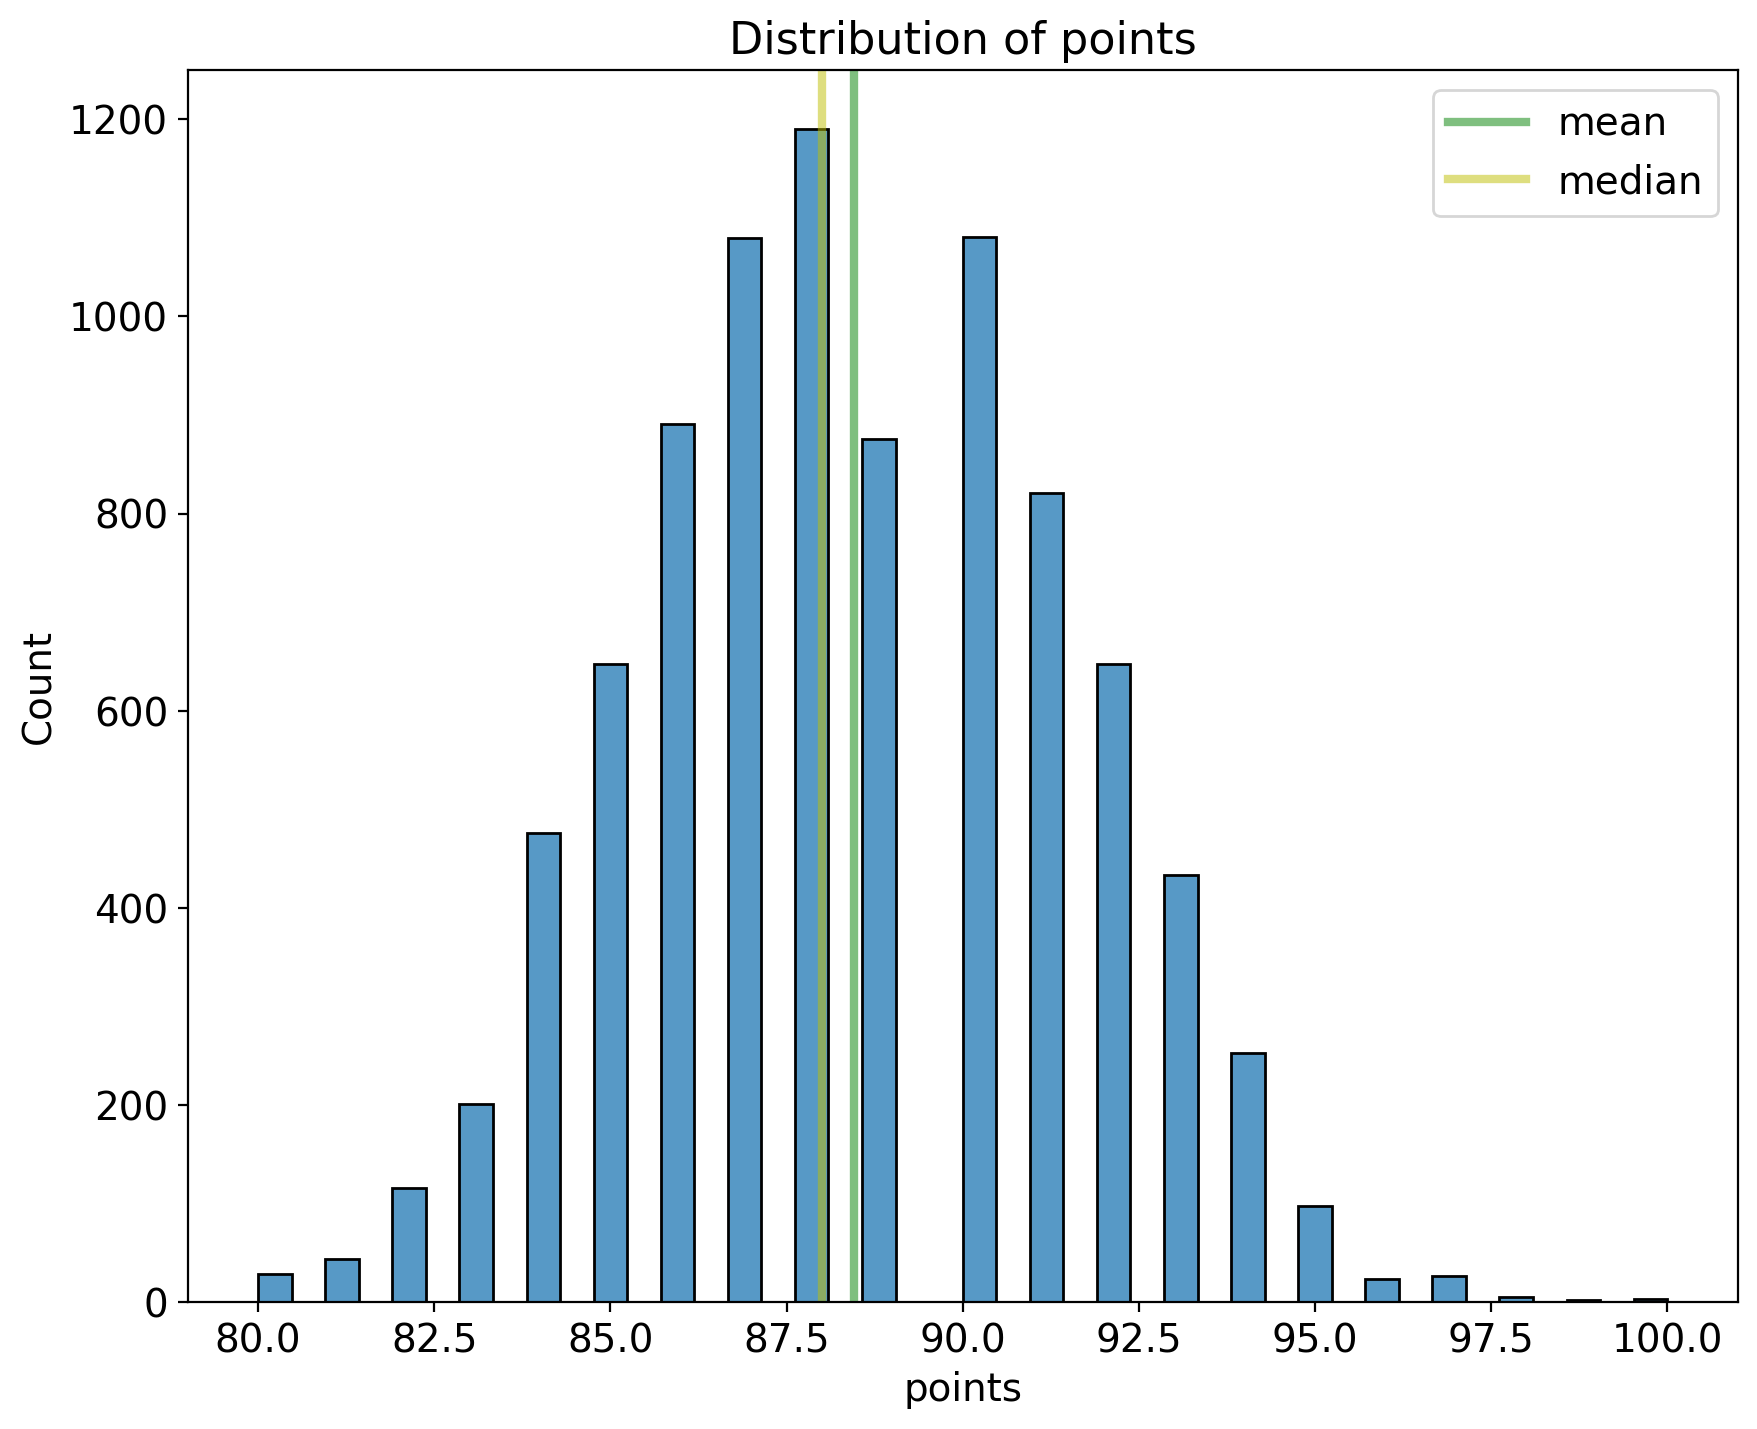

In [21]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, "points")

***Distribution*** is a description of a variable's range and how data is spread in that range.

Points show a normal distribution (a bell shaped curve obvious) as expected from a random variable. Range of wine points are distributed between 80 and 100 with the average (mean) of 88.45 and median (the middle value) of 88. Moreover, standard deviation, a measure of spread of a data range, is 3.03. Based on this statistics, we can confidently say that:

* 68% of the points lie in the 85.5 - 91.5 range
* 95% of the points lie in the 82.5 - 94.5 range
* 99% of the points lie in the 79.5 - 97.5 range

Alternatively, we can see the points as a classification of wines and interpret points as different classes according to [wine searcher](https://www.wine-searcher.com/critics-17-wine+enthusiast):

* 98–100: Classic
* 94–97: Superb
* 90–93: Excellent
* 87–89: Very good
* 83–86: Good
* 80–82: Acceptable

However, this would be different wine predictor, which we will not touch is scope of this project.